In [139]:
from madmex.wrappers import gwf_query
from madmex.util.xarray import to_float

from datacube.storage import masking
import numpy as np
import xarray as xr
from skimage.segmentation import slic
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [12, 8]
import folium
from affine import Affine
from rasterio import features
from rasterio.crs import CRS
from pyproj import Proj, transform
from descartes import PolygonPatch

from pprint import pprint
import os
import json

In [84]:
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "madmex.settings")
import django
django.setup()
from madmex.models import PredictObject
from django.contrib.gis.geos.geometry import GEOSGeometry

## Load a tile as xarray

In [2]:
gwf, tile_view = gwf_query(product='ls8_espa_mexico', region='Jalisco',
                           begin='2017-01-01', end='2017-02-28')
sr = gwf.load(list(tile_view)[1][1])
sr

<xarray.Dataset>
Dimensions:   (time: 14, x: 3334, y: 3334)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-05T17:11:46.381304 ...
  * y         (y) float64 1.026e+06 1.026e+06 1.026e+06 1.026e+06 1.026e+06 ...
  * x         (x) float64 2.377e+06 2.377e+06 2.378e+06 2.378e+06 2.378e+06 ...
Data variables:
    blue      (time, y, x) int16 -9999 -9999 -9999 -9999 -9999 -9999 -9999 ...
    green     (time, y, x) int16 -9999 -9999 -9999 -9999 -9999 -9999 -9999 ...
    red       (time, y, x) int16 -9999 -9999 -9999 -9999 -9999 -9999 -9999 ...
    nir       (time, y, x) int16 -9999 -9999 -9999 -9999 -9999 -9999 -9999 ...
    swir1     (time, y, x) int16 -9999 -9999 -9999 -9999 -9999 -9999 -9999 ...
    swir2     (time, y, x) int16 -9999 -9999 -9999 -9999 -9999 -9999 -9999 ...
    pixel_qa  (time, y, x) int16 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

## Retrieve some important spatial metadata from the xr Dataset

In [41]:
aff = Affine(*list(sr.affine)[0:6])
crs = sr.crs._crs.ExportToProj4()

## Apply no-data/cloud filtering and a reducer along time dimension

In [120]:
clear = masking.make_mask(sr.pixel_qa, cloud=False, cloud_shadow=False,
                          snow=False)
sr_clear = sr.where(clear)
sr_clear = sr_clear.drop('pixel_qa')
# Convert Landsat data to float (nodata values are converted to np.Nan)
sr_clear = sr_clear.apply(func=to_float, keep_attrs=True)
sr_clear['ndvi'] = (sr_clear.nir - sr_clear.red) / (sr_clear.nir + sr_clear.red)
sr_mean = sr_clear.mean('time', keep_attrs=True)
sr_mean

/home/madmex_user/.virtualenvs/antares/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/home/madmex_user/.virtualenvs/antares/lib/python3.5/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/home/madmex_user/.virtualenvs/antares/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/home/madmex_user/.virtualenvs/antares/lib/python3.5/site-packages/xarray/core/dtyp

<xarray.Dataset>
Dimensions:  (x: 3334, y: 3334)
Coordinates:
  * y        (y) float64 1.026e+06 1.026e+06 1.026e+06 1.026e+06 1.026e+06 ...
  * x        (x) float64 2.377e+06 2.377e+06 2.378e+06 2.378e+06 2.378e+06 ...
Data variables:
    blue     (y, x) float64 207.3 195.7 177.0 177.7 181.7 180.3 182.7 188.7 ...
    green    (y, x) float64 228.0 198.3 161.0 158.3 159.0 157.3 161.0 171.3 ...
    red      (y, x) float64 238.0 202.7 145.7 136.7 136.0 135.7 145.3 163.0 ...
    nir      (y, x) float64 428.0 349.7 211.3 187.7 181.0 172.0 192.0 224.0 ...
    swir1    (y, x) float64 469.0 369.7 202.0 184.0 175.3 173.0 207.3 230.7 ...
    swir2    (y, x) float64 307.0 241.7 136.3 120.3 113.3 112.0 129.3 149.7 ...
    ndvi     (y, x) float64 0.2076 0.205 0.1568 0.1486 0.142 0.1166 0.1339 ...
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

## Coerce xr Dataset to numpy array

In [121]:
sr_mean_arr = sr_mean.to_array().values
sr_mean_arr = np.moveaxis(sr_mean_arr, 0, 2)
sr_mean_arr.shape

(3334, 3334, 7)

## Run segmentation

In [122]:
segments_arr = slic(sr_mean_arr, compactness = 10, n_segments=100000, multichannel = True)

## Vectorize segments and format to geojson (includes reprojection to 4326)

In [131]:
# Reprojection function
def feature_transform(feat, crs_in, crs_out):
    """Reproject a feature
    """
    out_linearRing = []
    for point in feat['geometry']['coordinates'][0]: # LinearRing of the Polygon
        x, y =  point  # one point of the LinearRing
        long, lat = transform(crs_in, crs_out, x, y) # transform the point
        out_linearRing.append((long, lat)) # add all the points to the new LinearRing
    # transform the resulting LinearRing to  a Polygon and write it
    feat['geometry']['coordinates'] = [out_linearRing]
    return feat

    
# Format as valid feature collection
def to_valid_fc(fc):
    fc_out = {
      "type": "Feature",
      "geometry": {
        "type": fc[0]['type'],
        "coordinates": fc[0]['coordinates']
      },
      "properties": {
        "id": fc[1]
      }
    }
    return fc_out

# Vectorize
fc_proj = features.shapes(segments_arr.astype(np.uint16),
                         transform=aff)
fc_proj = [to_valid_fc(x) for x in fc_proj]
print(len(fc_proj))

# Transform
crs_in = Proj(crs)
crs_out = Proj(init='EPSG:4326')
# Warning no deep copy, so the fc_proj object is probably modified as well
# fc_ll = [feature_transform(x, crs_in, crs_out) for x in fc_proj]
# pprint(fc_ll[0])
# print(len(fc_ll))

14218


## Visualize

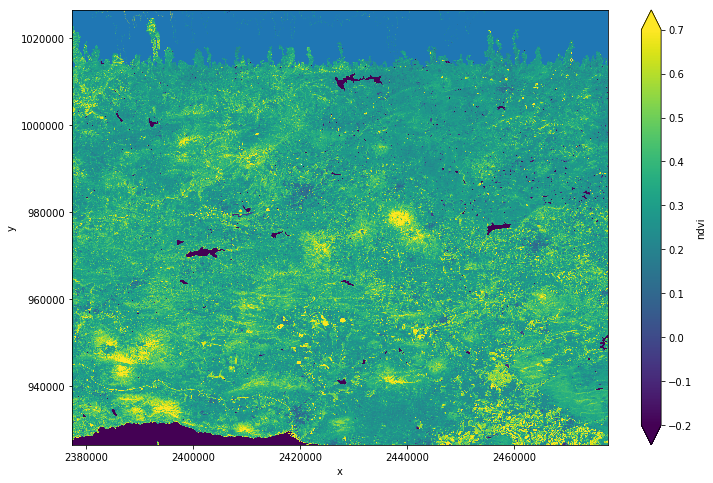

In [141]:
# segmentation_geojson = {"type": "FeatureCollection","features": fc_ll[1:300]}
# m = folium.Map(location=[21, -102],
#                tiles='OpenStreetMap')
# folium.GeoJson(segmentation_geojson).add_to(m)
# m
xr.plot.plot(sr_mean['ndvi'], vmin=-0.2, vmax=0.7)
ax = mpl.pyplot.gca()
patches = [PolygonPatch(feature['geometry'], facecolor='none', edgecolor="black",
                        linewidth=0.1)
           for feature in fc_proj[0:1000]]
ax.add_collection(mpl.collections.PatchCollection(patches))
    


## Write feature collection to Database

In [95]:
def predict_obj_builder(x):
    geom = GEOSGeometry(json.dumps(x['geometry']))
    obj = PredictObject(the_geom=geom)
    return obj

obj_list = [predict_obj_builder(x) for x in fc_ll]
PredictObject.objects.bulk_create(obj_list)

[<PredictObject: PredictObject object (2)>,
 <PredictObject: PredictObject object (3)>,
 <PredictObject: PredictObject object (4)>,
 <PredictObject: PredictObject object (5)>,
 <PredictObject: PredictObject object (6)>,
 <PredictObject: PredictObject object (7)>,
 <PredictObject: PredictObject object (8)>,
 <PredictObject: PredictObject object (9)>,
 <PredictObject: PredictObject object (10)>,
 <PredictObject: PredictObject object (11)>,
 <PredictObject: PredictObject object (12)>,
 <PredictObject: PredictObject object (13)>,
 <PredictObject: PredictObject object (14)>,
 <PredictObject: PredictObject object (15)>,
 <PredictObject: PredictObject object (16)>,
 <PredictObject: PredictObject object (17)>,
 <PredictObject: PredictObject object (18)>,
 <PredictObject: PredictObject object (19)>,
 <PredictObject: PredictObject object (20)>,
 <PredictObject: PredictObject object (21)>,
 <PredictObject: PredictObject object (22)>,
 <PredictObject: PredictObject object (23)>,
 <PredictObject: P